# Graph to Image Generation with SSIM Loss

This notebook demonstrates a graph neural network that generates a 128×128 RGB image from synthetic graph data. The model is trained using a combination of MSE loss and SSIM loss (Structural Similarity Index Measure) to encourage the generated image to match a target image both in pixel values and structure.

**File:** `graph_to_image_ssim.ipynb`

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: C:\Users\arash\anaconda3\envs\tgraphx\lib\site-packages\lpips\weights\v0.1\alex.pth

Training graph-to-image model with LPIPS loss...
Epoch 1: Loss = 0.2653
Epoch 2: Loss = 0.2101
Epoch 3: Loss = 0.2078
Epoch 4: Loss = 0.2064
Epoch 5: Loss = 0.2053
Epoch 6: Loss = 0.2045
Epoch 7: Loss = 0.2040
Epoch 8: Loss = 0.2036
Epoch 9: Loss = 0.2033
Epoch 10: Loss = 0.2031
Epoch 11: Loss = 0.2028
Epoch 12: Loss = 0.2025
Epoch 13: Loss = 0.2023
Epoch 14: Loss = 0.2023
Epoch 15: Loss = 0.2020
Epoch 16: Loss = 0.2018
Epoch 17: Loss = 0.2014
Epoch 18: Loss = 0.2010
Epoch 19: Loss = 0.2007
Epoch 20: Loss = 0.2006
Epoch 21: Loss = 0.2004
Epoch 22: Loss = 0.2003
Epoch 23: Loss = 0.2002
Epoch 24: Loss = 0.2000
Epoch 25: Loss = 0.1998
Epoch 26: Loss = 0.1996
Epoch 27: Loss = 0.1994
Epoch 28: Loss = 0.1991
Epoch 29: Loss = 0.1990
Epoch 30: Loss = 0.1988
Epoch 31: Loss = 0.1987
Epoch 32: Loss = 0.1985
Epoch 33: Loss 

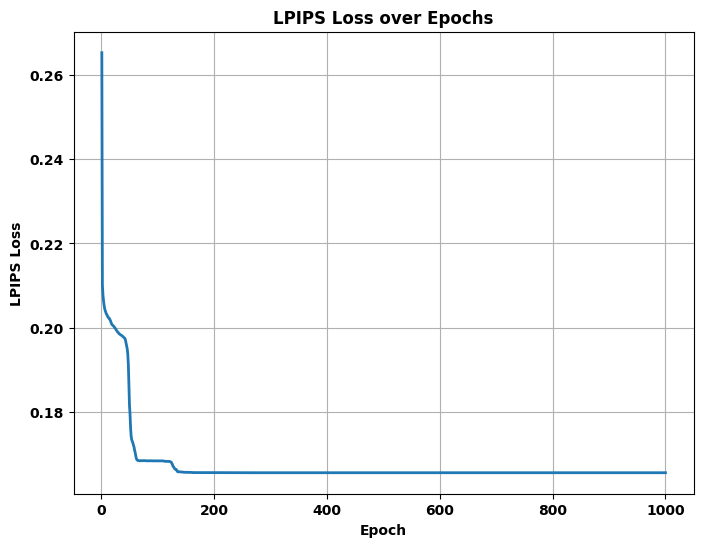

Training complete!


In [5]:
# graph_to_image_lpips.ipynb

import math
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import lpips  # Make sure to install lpips via: pip install lpips

# Import our GNN modules from our library
from models.graph_classifier import GraphClassifier
from core.graph import Graph, GraphBatch
from core.dataloader import GraphDataset, GraphDataLoader
from core.utils import get_device

#############################################
#   LPIPS Loss Setup
#############################################
# Initialize the LPIPS loss using the Alex network.
lpips_criterion = lpips.LPIPS(net='alex')
device = get_device()  # obtain device early
lpips_criterion = lpips_criterion.to(device)  # ensure LPIPS model is on the same device

# We define a helper function to compute LPIPS loss.
def lpips_loss_fn(pred, target):
    # Normalize images to [-1, 1] using tanh (assuming inputs are roughly centered)
    pred_norm = torch.tanh(pred)
    target_norm = torch.tanh(target)
    return lpips_criterion(pred_norm, target_norm).mean()

#############################################
#   Custom Collate Function for (graph, label) pairs
#############################################

def graph_label_collate_fn(batch):
    """Custom collate function to batch a list of (Graph, label) tuples."""
    graphs, labels = zip(*batch)
    return GraphBatch(graphs), torch.stack(labels)

#############################################
#   Synthetic Dataset Generation
#############################################

# Parameters
num_graphs = 50                # total number of graphs
num_nodes = 16                 # each graph has 16 nodes (patches)
num_edges = 40                 # arbitrary number of edges per graph
in_shape = (3, 32, 32)         # each node is a 32x32 RGB patch
hidden_shape = (16, 32, 32)    # hidden representation for each node (channels, H, W)
output_image_shape = (3, 128, 128)  # desired output image (RGB, 128x128)
# The model will output a vector of size 3*128*128 = 49152
num_classes = output_image_shape[0] * output_image_shape[1] * output_image_shape[2]
num_epochs = 1000
lr = 0.05

graphs = []
labels_list = []
for i in range(num_graphs):
    # Create a graph with 16 nodes
    node_features = torch.randn(num_nodes, *in_shape)
    edge_index = torch.randint(0, num_nodes, (2, num_edges))
    graph = Graph(node_features, edge_index)
    graphs.append(graph)
    # Generate a synthetic target image (for example, random noise)
    target_image = torch.randn(*output_image_shape)  # you can also use torch.rand(...)
    labels_list.append(target_image)

# Device setup: move graphs and labels to device
for graph in graphs:
    graph.to(device)
labels_list = [lbl.to(device) for lbl in labels_list]

# Create dataset and dataloader using the custom collate function
dataset = GraphDataset(list(zip(graphs, labels_list)))
dataloader = GraphDataLoader(dataset, batch_size=5, shuffle=True, collate_fn=graph_label_collate_fn)

#############################################
#   Model, Loss, and Optimizer Setup
#############################################

# The model outputs a vector that will be reshaped into an image.
model = GraphClassifier(
    in_shape=in_shape,
    hidden_shape=hidden_shape,
    num_classes=num_classes,  # output dimension = 3*128*128
    num_layers=2,
    pooling='mean'
)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

#############################################
#   Training Loop
#############################################

loss_values = []

print("\nTraining graph-to-image model with LPIPS loss...")
for epoch in range(1, num_epochs + 1):
    model.train()
    epoch_loss = 0.0
    for batch, batch_labels in dataloader:
        optimizer.zero_grad()
        logits = model(batch.node_features, batch.edge_index, batch.edge_features, batch.batch)
        # Reshape logits to [batch_size, 3, 128, 128]
        logits = logits.view(-1, *output_image_shape)
        loss = lpips_loss_fn(logits, batch_labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * batch_labels.size(0)
    epoch_loss /= num_graphs
    loss_values.append(epoch_loss)
    print(f"Epoch {epoch}: Loss = {epoch_loss:.4f}")

#############################################
#   Plotting Learning Curve (Loss)
#############################################

plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), loss_values, linewidth=2)
plt.title("LPIPS Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("LPIPS Loss")
plt.grid(True)
plt.show()

print("Training complete!")


In [7]:
import cv2
import numpy as np

# Switch model to evaluation mode
model.eval()

# Pick one sample from the dataset (here, the first one)
sample_graph, sample_label = dataset[0]  # sample_label shape: (3, 128, 128)
sample_graph.to(device)

# Create a GraphBatch from the single sample (the GraphBatch expects a list of Graphs)
batch = GraphBatch([sample_graph])
# Ensure the batch is on the proper device (its tensors should already be on device)
with torch.no_grad():
    output = model(batch.node_features, batch.edge_index, batch.edge_features, batch.batch)
    # Reshape output to [batch_size, 3, 128, 128] (here batch_size==1)
    output = output.view(-1, *output_image_shape)

# Get predicted image and target image as NumPy arrays
pred_img = output[0].cpu().numpy()  # shape: (3, 128, 128)
target_img = sample_label.cpu().numpy()  # shape: (3, 128, 128)

# Define a helper to normalize an image to [0, 255]
def normalize_image(img):
    img = img - np.min(img)
    if np.max(img) > 0:
        img = img / np.max(img)
    return (img * 255).astype(np.uint8)

pred_img = normalize_image(pred_img)
target_img = normalize_image(target_img)

# Rearrange channels from (C, H, W) to (H, W, C)
pred_img = np.transpose(pred_img, (1, 2, 0))
target_img = np.transpose(target_img, (1, 2, 0))

# Convert from RGB to BGR for OpenCV (if desired)
pred_img = cv2.cvtColor(pred_img, cv2.COLOR_RGB2BGR)
target_img = cv2.cvtColor(target_img, cv2.COLOR_RGB2BGR)

# Concatenate the target image (left) and the generated image (right) side by side
comparison = cv2.hconcat([target_img, pred_img])

# Save the combined image
cv2.imwrite("comparison.png", comparison)

print("Saved side-by-side comparison as 'comparison.png'.")


Saved side-by-side comparison as 'comparison.png'.
